In [3]:
import pandas as pd 
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm 
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, LineString

In [4]:
#TODO: start looking at the national level. Which are the unexpected links from nat. to local!? 

In [5]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"

#we are bringing in the data with demographic information and cluster ids 
#hence, merged
#MVP path merged = pd.read_csv("/shared/3/projects/benlitterer/localNews/data/interim/SingleNE_85_clustered.tsv", sep="\t")
merged = pd.read_csv(IN_PATH, sep="\t")
merged = merged.dropna(subset=["clustNum"]) 

#first make sure we have the date of an outlet correctly specified 
merged["date"] = pd.to_datetime(merged["date"])

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,3,10,11,12,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#variables that we will merge into graph after creating it
#in networkx
demVars = ["clustNum", "source"]

#get pairwise information
#by sorting in this way then calling drop_duplicates, we only consider the first mention of a story by 
#an outlet. Simplifies the analysis but introduces an assumption 
#example: merged.head(300)[["clustNum", "source", "date"]].sort_values(["clustNum", "source", "date"]).head(20)
pairwise = merged.sort_values(["clustNum", "source", "date"]).drop_duplicates(subset=["clustNum", "source"])

#group into clusters
pairwise = pairwise.loc[:, ["key"] + demVars]
pairwise = pairwise.groupby(by="clustNum").agg(list)
pairwise["clustSize"] = pairwise["source"].apply(len)

#NOTE: we remove very large clusters? because they slow down getting pairwise information 
pairwise = pairwise[pairwise["clustSize"] < 2000].drop(columns=["clustSize"])

#get pairs of sources, with no duplicate pairs 
def getPairwise(inList):
    outList = []
    for i in range(0, len(inList)-1): 
        for j in range(i + 1, len(inList)): 
            outList.append((inList[i], inList[j]))
    return outList

#applied across an entire series 
def getPairwiseSeries(inSeries): 
    return inSeries.apply(getPairwise)

pairwise["source"] = pairwise["source"].apply(getPairwise)
pairwise = pairwise.explode(["source"])
#pairwise[["date1", "date2"]] = pd.DataFrame(pairwise["date"].tolist(), index=pairwise.index)

In [8]:
pairwise = pairwise.dropna()
pairwise[["source1", "source2"]] = pd.DataFrame(pairwise["source"].tolist(), index=pairwise.index)
pairwise[["source1", "source2"]] = np.sort(pairwise[["source1", "source2"]], axis=1)

In [9]:
def getEdgeWeights(inDf):
    totalEdges = len(inDf)
    grouped = inDf
    grouped["edgeCount"] = 1
    
    #get the percent of edges that are between each node
    grouped = grouped[["source1", "source2", "edgeCount"]].groupby(by=["source1", "source2"]).agg(lambda x: (sum(x) / totalEdges) * 100)
    
    return grouped.to_dict(orient="index")

In [11]:
#now, create our config model 
#create graph from pandas dataframe. Allow parallel edges!
outletGraph = nx.from_pandas_edgelist(pairwise[["source1", "source2"]], source="source1", target="source2", create_using=nx.MultiGraph)

In [28]:
nullWeights = {}

#config model runs 
CONFIG_RUNS = 20
for i in tqdm(range(CONFIG_RUNS)):

    #create config model 
    #the config model creates a graph with the number of in and out degrees that we see in our graph 
    #the nodes are random though, so we are assuming that there is no relationship between 
    #any node characteristics and their degrees 
    print("creating config model")
    degree = [tup[1] for tup in outletGraph.degree()]
    configModel = nx.configuration_model(degree)

    #NOTE: we have a different number of edges now so we will need to scale by that! 
    #configModel.remove_edges_from(nx.selfloop_edges(configModel))

    print("adding node names")
    #set the config model to have the same nodes and attributes as the original model 
    nodeMapping = dict(zip(list(configModel.nodes()), list(outletGraph.nodes())))
    configModel = nx.relabel_nodes(configModel, nodeMapping)
    
    print("getting edges in dataframe")
    #get the edges from the graph
    edgeDf = nx.to_pandas_edgelist(configModel, source="source1", target="source2")
    edgeDf[["source1", "source2"]] = np.sort(edgeDf[["source1", "source2"]], axis=1)
    
    #edgeSums is a dictionary with edges (node pairs) as keys
    #and total shared stories as values
    edgeSums = getEdgeWeights(edgeDf)
    
    print("adding weights to dict")
    #add these edge weights to our distribution of 
    #edge weights 
    for k in edgeSums.keys(): 
        currWeight = edgeSums[k]["edgeCount"]
        if k not in nullWeights:
            nullWeights[k] = [currWeight]
        else: 
            nullWeights[k].append(currWeight)

  0%|          | 0/20 [00:00<?, ?it/s]

creating config model
adding node names
getting edges in dataframe


  5%|▌         | 1/20 [01:08<21:45, 68.72s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 10%|█         | 2/20 [02:11<19:38, 65.46s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 15%|█▌        | 3/20 [03:14<18:14, 64.36s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 20%|██        | 4/20 [04:20<17:15, 64.74s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 25%|██▌       | 5/20 [05:23<16:03, 64.24s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 30%|███       | 6/20 [06:27<14:57, 64.13s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 35%|███▌      | 7/20 [07:34<14:05, 65.07s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 40%|████      | 8/20 [08:39<13:01, 65.11s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 45%|████▌     | 9/20 [09:46<12:01, 65.58s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 50%|█████     | 10/20 [10:54<11:02, 66.29s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 55%|█████▌    | 11/20 [12:01<10:00, 66.73s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 60%|██████    | 12/20 [13:10<08:57, 67.20s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 65%|██████▌   | 13/20 [14:15<07:46, 66.69s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 70%|███████   | 14/20 [15:20<06:36, 66.15s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 75%|███████▌  | 15/20 [16:25<05:28, 65.72s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 80%|████████  | 16/20 [17:31<04:23, 65.90s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 85%|████████▌ | 17/20 [18:33<03:14, 64.81s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 90%|█████████ | 18/20 [19:38<02:09, 64.82s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


 95%|█████████▌| 19/20 [20:43<01:04, 64.70s/it]

adding weights to dict
creating config model
adding node names
getting edges in dataframe


100%|██████████| 20/20 [21:50<00:00, 65.50s/it]

adding weights to dict


In [30]:
import pickle
NULL_WEIGHT_PATH = "/shared/3/projects/newsDiffusion/data/interim/configModel/modelWeights/" + "nullWeights_4_10.pkl"
with open(NULL_WEIGHT_PATH, 'wb') as handle:
    pickle.dump(nullWeights, handle)

In [21]:
#NOTE: we can sanity check our config model by 
#making sure that the degrees are the same between these
#NOTE: bias due to removing self-edges
#configModel.degree
#outletGraph.degree

In [22]:
#get a count of edgeWeights in our current graph 
observedWeights = getEdgeWeights(pairwise)

In [44]:
CONFIG_RUNS =20

In [48]:
def getZScore(observed, inList): 
    return (observed - np.mean(inList)) / np.std(inList)

standardWeights = {}
count = 0
for k in observedWeights.keys(): 
    observed = observedWeights[k]["edgeCount"]
    if k in nullWeights: 
        nullVals = nullWeights[k]
        padded = nullVals + [0 for i in range(0, CONFIG_RUNS-len(nullVals))]
        zScore = getZScore(observed, padded)
        standardWeights[k] = zScore
    else: 
        #very very rare that this happens 
        #this means that our null model NEVER produced this edge
        #so very large z-score? 
        standardWeights[k] = 5000
    

In [49]:
#perhaps we can set these to the highest zscore later? 
counter = 0 
for k, v in standardWeights.items(): 
    if v == 5000: 
        counter += 1
counter / len(standardWeights.keys())

0.011924440281374548

In [182]:
#put weights into a dataframe for easier manipulation
sWeightsDf = pd.DataFrame.from_dict(standardWeights, orient="index", columns=["zScore"]).reset_index()
sWeightsDf[["source1", "source2"]] = pd.DataFrame(sWeightsDf["index"].tolist(), index=sWeightsDf.index)

(-10.0, 10.0)

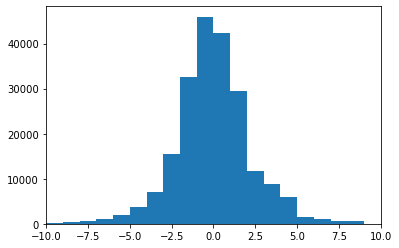

In [183]:
plt.hist(sWeightsDf["zScore"], bins=np.arange(-10, 10, 1))
plt.xlim(-10, 10)

In [242]:
natOutlets = merged.loc[merged["national"] == True, ["source", "lat", "lon", "national"]].drop_duplicates(["source"]).drop_duplicates()
print(len(natOutlets))

LAT_MAX = 50
LAT_MIN = 20
natOutlets["lat"] = np.arange(LAT_MIN, LAT_MAX, (LAT_MAX - LAT_MIN) / len(natOutlets))
natOutlets["lon"] = -62

print(len(natOutlets))

localOutlets = merged.loc[merged["national"] == False, ["source", "lat", "lon", "national"]].drop_duplicates(["source"]).drop_duplicates()
outletDf = pd.concat([localOutlets, natOutlets], axis=0)

477
477


In [244]:
outletDf.tail()

,source,lat,lon,national
2441075,bnnbloomberg,49.685535,-62.0,True
2441079,trumptimes,49.748428,-62.0,True
2441718,sustainablepulse,49.811321,-62.0,True
2441800,offguardian,49.874214,-62.0,True
2442277,occupyyourself,49.937107,-62.0,True


In [186]:
#now merge in our lat/lon information 
#TODO: extend to have everything we're interested in 
#we use this to merge demographic variables onto our configuration model network 

temp = pd.merge(sWeightsDf, outletDf.rename(columns={"source":"source1"}), on="source1", how="left")
temp = pd.merge(temp, outletDf.rename(columns={"source":"source2"}), on="source2", how="left")

In [187]:
sWeightsDf = temp
sWeightsDf["coord_x"] = list(zip(sWeightsDf["lon_x"], sWeightsDf["lat_x"]))
sWeightsDf["coord_y"] = list(zip(sWeightsDf["lon_y"], sWeightsDf["lat_y"]))
sWeightsDf["geoPair"] = sWeightsDf.apply(lambda x: [x["coord_x"], x["coord_y"]], axis=1)


In [188]:
states = gpd.read_file("/home/blitt/reference/geospatial/shapeFiles/cb_2018_us_state_5m")

In [214]:
#get the lat,lon pairs formatted as lines 
lines = [LineString(item) for item in sWeightsDf["geoPair"]]
lineGdf = gpd.GeoDataFrame(sWeightsDf, geometry=lines)

In [215]:
#get only national-local edges
#so national for one source must be reversed for the other
linksNat = lineGdf[lineGdf["national_x"] !=  lineGdf["national_y"]]

#get the top 3000 local-nat links in terms of their zScore
NUM_NAT = 3000
topNat = linksNat.sort_values("zScore", ascending=False).head(NUM_NAT)

#now get only those sources with a large degree
natLinkGraph = nx.from_pandas_edgelist(topNat[["source1", "source2"]], source="source1", target="source2", create_using=nx.MultiGraph)

#count the degrees of outlets in this filtered network of local-national 
degreeCounts = pd.DataFrame([tup for tup in natLinkGraph.degree()], columns=["source", "count"])

In [216]:
#we want national outlets that share with many local outlets 
#so just need the degree for national outlets 
degreeCounts = degreeCounts[degreeCounts["source"].isin(natOutlets["source"])]

NAT_DEGREE_CUTOFF = 10
highDegOutlets = list(degreeCounts.head(NAT_DEGREE_CUTOFF)["source"])

In [217]:
#get the mixed links that have a national outlet with high degree
keepMixed = linksNat[linksNat["source1"].isin(highDegOutlets) | linksNat["source1"].isin(highDegOutlets)]

#we want top # of local-local edges, and the mixed edges we just described 
LOCAL_EDGES = 3000
localEdges = lineGdf[(lineGdf["national_x"] == False) & (lineGdf["national_y"] == False)]
keepLocal = localEdges.sort_values("zScore", ascending=False).head(LOCAL_EDGES)

allEdges = pd.concat([keepLocal, keepMixed], axis=0)

(20.0, 50.0)

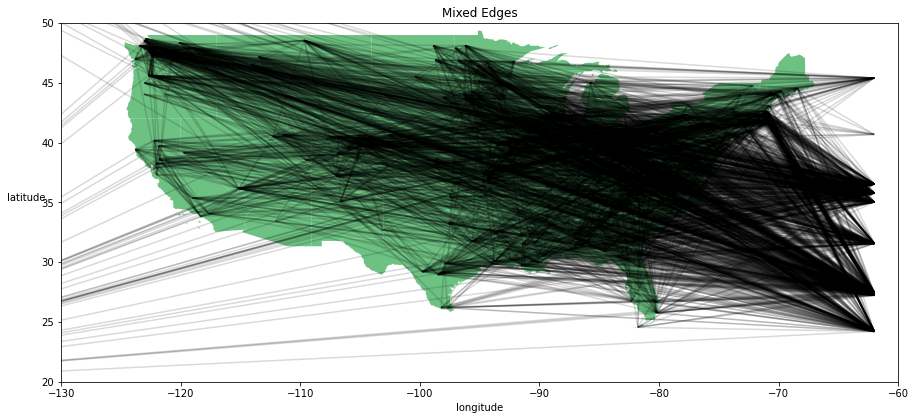

In [254]:
allEdges.plot(ax=states.plot(figsize=(15, 10), color="#6dc283"), color="black", alpha=.15)

#need to think about scaling for the number of articles produced? 
#obviously small outlets aren't going to have many connections 
plt.title("Local Edges and ")
plt.xlabel("longitude")
plt.ylabel("latitude", rotation=0, labelpad=15)
plt.xlim([-130, -60])
plt.ylim([20, 50])

In [260]:
plotOutlets = set(list(allEdges["source1"].unique()) + list(allEdges["source2"].unique()))

In [261]:
HTML_PATH = "/home/blitt/projects/localNews/notebooks/similarityAnalysis/plotly/mixedEdges.html"
localOutlets = merged.loc[merged["national"] == False, ["source", "lat", "lon", "national"]].drop_duplicates(["source"]).drop_duplicates()
outletDf = pd.concat([localOutlets, natOutlets], axis=0)
outletDf["displayText"] = outletDf["source"]

outletDf = outletDf[outletDf["source"].isin(plotOutlets)]

import plotly.graph_objects as go
import pandas as pd

fig = go.Figure()

flight_paths = []
for i, row in allEdges.iterrows():
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [row["lon_x"], row["lon_y"]],
            lat = [row["lat_x"], row["lat_y"]],
            mode = 'lines',
            hoverinfo = "none", 
            line = dict(width = 1,color = 'black')
            #opacity = np.log(row["zScore"]) / np.log(max(topEdges["zScore"]))
        )
    )

    
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = outletDf['lon'],
    lat = outletDf['lat'],
    hoverinfo = 'text',
    text = outletDf['displayText'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))


    
fig.update_layout(
    title_text = '',
    showlegend = False,
    geo = dict(
        scope = 'north america',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'grey',
        showsubunits = True
    ),
)

fig.write_html(HTML_PATH)

(20.0, 50.0)

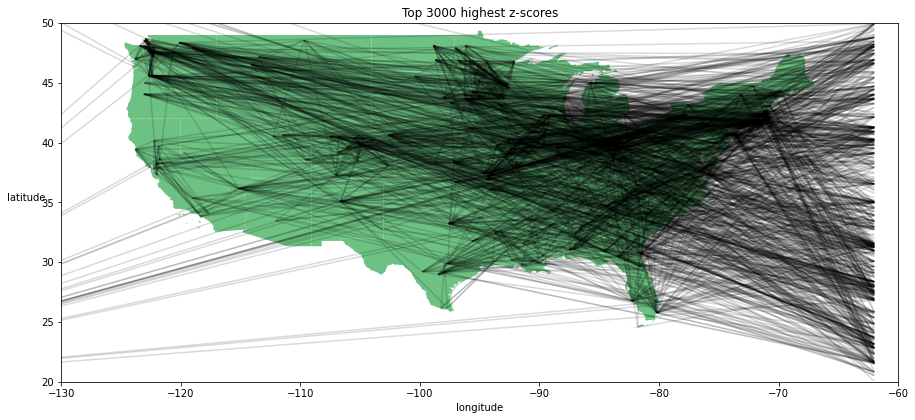

In [233]:
NUM_EDGES = 3000

noNatNat = lineGdf[(lineGdf["national_x"] == False) | (lineGdf["national_y"] == False)]
topEdges = noNatNat.sort_values("zScore", ascending=False).head(NUM_EDGES)
topEdges.plot(ax=states.plot(figsize=(15, 10), color="#6dc283"), color="black", alpha=.15)

#need to think about scaling for the number of articles produced? 
#obviously small outlets aren't going to have many connections 
plt.title("Top " + str(NUM_EDGES) + " highest z-scores")
plt.xlabel("longitude")
plt.ylabel("latitude", rotation=0, labelpad=15)
plt.xlim([-130, -60])
plt.ylim([20, 50])

In [ ]:
plotOutlets = set(list(topEdges["source1"].unique()) + list(topEdges["source2"].unique()))

In [ ]:
localOutlets = merged.loc[merged["national"] == False, ["source", "lat", "lon", "national"]].drop_duplicates(["source"]).drop_duplicates()
outletDf = pd.concat([localOutlets, natOutlets], axis=0)
outletDf["displayText"] = outletDf["source"]

outletDf = outletDf[outletDf["source"].isin(plotOutlets)]

In [236]:
HTML_PATH = "/home/blitt/projects/localNews/notebooks/similarityAnalysis/plotly/mixedEdgesCutoff.html"
outletDf = merged[["source", "city", "lat", "lon", "state"]].drop_duplicates(["source"]).drop_duplicates()
outletDf["displayText"] = outletDf["source"] + " - " + outletDf["city"] + ", " + outletDf["state"]

import plotly.graph_objects as go
import pandas as pd

fig = go.Figure()

flight_paths = []
for i, row in topEdges.iterrows():
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [row["lon_x"], row["lon_y"]],
            lat = [row["lat_x"], row["lat_y"]],
            mode = 'lines',
            hoverinfo = "none", 
            line = dict(width = 1,color = 'black'),
            opacity = .1
        )
    )

    
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = outletDf['lon'],
    lat = outletDf['lat'],
    hoverinfo = 'text',
    text = outletDf['displayText'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))


    
fig.update_layout(
    title_text = '',
    showlegend = False,
    geo = dict(
        scope = 'north america',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'grey',
        showsubunits = True
    ),
)

fig.write_html(HTML_PATH)

In [141]:
lines = [LineString(item) for item in sWeightsDf["geoPair"]]
lineGdf = gpd.GeoDataFrame(sWeightsDf, geometry=lines)

NUM_EDGES = 1500
topEdges = lineGdf[lineGdf["zScore"] < 3000]
topEdges = topEdges[(topEdges["source1"].isin(topNatOutlets)) & (topEdges["source1"].isin(topNatOutlets))]
topEdges = lineGdf.sort_values("zScore", ascending=False).head(NUM_EDGES)

HTML_PATH = "/home/blitt/projects/localNews/notebooks/similarityAnalysis/plotly/testPlot.html"


In [249]:
plotOutlets = set(list(topEdges["source1"].unique()) + list(topEdges["source2"].unique()))

In [250]:
import plotly.graph_objects as go
import pandas as pd

natOutlets = merged.loc[merged["national"] == True, ["source", "lat", "lon", "national"]].drop_duplicates(["source"]).drop_duplicates()

LAT_MAX = 50
LAT_MIN = 20
natOutlets["lat"] = np.arange(LAT_MIN, LAT_MAX, (LAT_MAX - LAT_MIN) / len(natOutlets))
natOutlets["lon"] = -62

localOutlets = merged.loc[merged["national"] == False, ["source", "lat", "lon", "national"]].drop_duplicates(["source"]).drop_duplicates()
outletDf = pd.concat([localOutlets, natOutlets], axis=0)
outletDf["displayText"] = outletDf["source"]

outletDf = outletDf[outletDf["source"].isin(plotOutlets)]

In [251]:
df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df_airports.head()

df_flight_paths = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_aa_flight_paths.csv')
df_flight_paths.head()

fig = go.Figure()

flight_paths = []
for i, row in topEdges.iterrows():
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [row["lon_x"], row["lon_y"]],
            lat = [row["lat_x"], row["lat_y"]],
            mode = 'lines',
            hoverinfo = "none", 
            line = dict(width = 1,color = 'black'),
            opacity = np.log(row["zScore"]) / np.log(max(topEdges["zScore"]))
        )
    )

    
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = outletDf['lon'],
    lat = outletDf['lat'],
    hoverinfo = 'text',
    text = outletDf['displayText'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))


fig.update_layout(
    title_text = '',
    showlegend = False,
    geo = dict(
        scope = 'north america',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'grey',
        showsubunits = True
    ),
)

fig.write_html(HTML_PATH)

In [139]:
lines = [LineString(item) for item in sWeightsDf["geoPair"]]
lineGdf = gpd.GeoDataFrame(sWeightsDf, geometry=lines)

NUM_EDGES = 3000
topEdges = lineGdf[lineGdf["zScore"] < 3000]
topEdges.head(10)

,index,zScore,source1,source2,lat_x,lon_x,lat_y,lon_y,coord_x,coord_y,geoPair,geometry
0,"(21stcenturywire, abcnews)",-2.333921,21stcenturywire,abcnews,33.773585,-62.0,25.786164,-62.000000,"(-62.0, 33.77358490566067)","(-62.0, 25.7861635220127)","[(-62.0, 33.77358490566067), (-62.0, 25.786163...","LINESTRING (-62.00000 33.77358, -62.00000 25.7..."
1,"(21stcenturywire, acnlatitudes)",1.028992,21stcenturywire,acnlatitudes,33.773585,-62.0,32.955975,-62.000000,"(-62.0, 33.77358490566067)","(-62.0, 32.95597484276757)","[(-62.0, 33.77358490566067), (-62.0, 32.955974...","LINESTRING (-62.00000 33.77358, -62.00000 32.9..."
2,"(21stcenturywire, activistpost)",3.870140,21stcenturywire,activistpost,33.773585,-62.0,23.207547,-62.000000,"(-62.0, 33.77358490566067)","(-62.0, 23.207547169811388)","[(-62.0, 33.77358490566067), (-62.0, 23.207547...","LINESTRING (-62.00000 33.77358, -62.00000 23.2..."
3,"(21stcenturywire, addisoncountyindependent)",0.420084,21stcenturywire,addisoncountyindependent,33.773585,-62.0,44.015337,-73.167340,"(-62.0, 33.77358490566067)","(-73.16734, 44.0153371)","[(-62.0, 33.77358490566067), (-73.16734, 44.01...","LINESTRING (-62.00000 33.77358, -73.16734 44.0..."
4,"(21stcenturywire, adobochronicles)",4.358899,21stcenturywire,adobochronicles,33.773585,-62.0,36.415094,-62.000000,"(-62.0, 33.77358490566067)","(-62.0, 36.41509433962298)","[(-62.0, 33.77358490566067), (-62.0, 36.415094...","LINESTRING (-62.00000 33.77358, -62.00000 36.4..."
5,"(21stcenturywire, advertiserdemocrat)",0.229416,21stcenturywire,advertiserdemocrat,33.773585,-62.0,44.213957,-70.544810,"(-62.0, 33.77358490566067)","(-70.5448096, 44.2139566)","[(-62.0, 33.77358490566067), (-70.5448096, 44....","LINESTRING (-62.00000 33.77358, -70.54481 44.2..."
6,"(21stcenturywire, ageofautism)",4.276180,21stcenturywire,ageofautism,33.773585,-62.0,37.484277,-62.000000,"(-62.0, 33.77358490566067)","(-62.0, 37.484276729560115)","[(-62.0, 33.77358490566067), (-62.0, 37.484276...","LINESTRING (-62.00000 33.77358, -62.00000 37.4..."
7,"(21stcenturywire, airwars)",7.000000,21stcenturywire,airwars,33.773585,-62.0,35.408805,-62.000000,"(-62.0, 33.77358490566067)","(-62.0, 35.40880503144686)","[(-62.0, 33.77358490566067), (-62.0, 35.408805...","LINESTRING (-62.00000 33.77358, -62.00000 35.4..."
8,"(21stcenturywire, alamedatimesstar)",-1.586396,21stcenturywire,alamedatimesstar,33.773585,-62.0,37.779872,-122.282185,"(-62.0, 33.77358490566067)","(-122.2821855, 37.7798721)","[(-62.0, 33.77358490566067), (-122.2821855, 37...","LINESTRING (-62.00000 33.77358, -122.28219 37...."
9,"(21stcenturywire, alaskajournalofcommerce)",0.000000,21stcenturywire,alaskajournalofcommerce,33.773585,-62.0,61.218056,-149.900278,"(-62.0, 33.77358490566067)","(-149.90027780000003, 61.2180556)","[(-62.0, 33.77358490566067), (-149.90027780000...","LINESTRING (-62.00000 33.77358, -149.90028 61...."
